Problem Statement:
# What features are customers identifying in the category of Grocery and Gourmet Food in Amazon through their questions, and are these questions being anwered?

A Capstone project applying NLP modeling to Amazon Question and Answer banks 

by Robert Spoonmore

# Data Source:
https://jmcauley.ucsd.edu/data/amazon/qa/qa_Grocery_and_Gourmet_Food.json.gz

***Citation:***

Modeling ambiguity, subjectivity, and diverging viewpoints in opinion question answering systems
Mengting Wan, Julian McAuley
International Conference on Data Mining (ICDM), 2016

Addressing complex and subjective product-related queries with customer reviews
Julian McAuley, Alex Yang
World Wide Web (WWW), 2016

# Data Import Instructions:

***Reading the data***
Data can be treated as python dictionary objects. A simple script to read any of the above the data is as follows:

def parse(path): g = gzip.open(path, 'r') for l in g: yield eval(l)


***Convert to 'strict' json***
The above data can be read with python 'eval', but is not strict json. If you'd like to use some language other than python, you can convert the data to strict json as follows:

import json import gzip def parse(path): g = gzip.open(path, 'r') for l in g: yield json.dumps(eval(l)) f = open("output.strict", 'w') for l in parse("qa_Video_Games.json.gz"): f.write(l + '\n')


***Pandas data frame***
This code reads the data into a pandas data frame:

import pandas as pd import gzip def parse(path): g = gzip.open(path, 'rb') for l in g: yield eval(l) def getDF(path): i = 0 df = {} for d in parse(path): df[i] = d i += 1 return pd.DataFrame.from_dict(df, orient='index') df = getDF('qa_Video_Games.json.gz')

In [1]:
# special IPython command to prepare the notebook for matplotlib and other libraries
%matplotlib inline 

import json
import numpy as np
import pandas as pd
import gzip
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sklearn
import nltk
#import pprint
#from gensim import corpora
import re
from gensim.models import doc2vec, Word2Vec, KeyedVectors
from gensim.models.doc2vec import TaggedDocument
from gensim.parsing.preprocessing import remove_stopwords
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial import distance

In [2]:
# Define path for Amazon data
path = r'Capstone_Dataset/qa_Grocery_and_Gourmet_Food.json.gz'

***Data Structure***

asin - ID of the product

questionType - type of question. Could be 'yes/no' or 'open-ended'

answerType - type of answer. Could be 'Y', 'N', or '?' (if the polarity of the answer could not be predicted). 

Only present for yes/no questions.

answerTime - raw answer timestamp

unixTime - answer timestamp converted to unix time

question - question text

answer - answer text

In [3]:
def parse(path): 
    g = gzip.open(path, 'rb') 
    for l in g: 
        yield eval(l) 
        
def getDF(path): 
    i = 0 
    df = {} 
    for d in parse(path): 
        df[i] = d 
        i += 1 
    return pd.DataFrame.from_dict(df, orient='index') 

food_df = getDF(path)

In [4]:
print("shape: ",food_df.shape,"\n")
print("columns: ",food_df.columns,"\n")
print("DF info: ",food_df.info(),"\n")

shape:  (19538, 7) 

columns:  Index(['questionType', 'asin', 'answerTime', 'unixTime', 'question', 'answer',
       'answerType'],
      dtype='object') 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19538 entries, 0 to 19537
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   questionType  19538 non-null  object 
 1   asin          19538 non-null  object 
 2   answerTime    19538 non-null  object 
 3   unixTime      18930 non-null  float64
 4   question      19538 non-null  object 
 5   answer        19538 non-null  object 
 6   answerType    7294 non-null   object 
dtypes: float64(1), object(6)
memory usage: 1.2+ MB
DF info:  None 



In [5]:
food_df[['question','answer']] = food_df[['question','answer']].astype(str)
food_df.head()

,questionType,asin,answerTime,unixTime,question,answer,answerType
0,open-ended,9742356831,"Mar 26, 2014",1.395817e+09,What is the heat of this compared to the yello...,I think that the yellow is the most mild. The ...,NaN
1,yes/no,9742356831,"Apr 2, 2014",1.396422e+09,Is there MSG in it?,No MSG in Mae Ploy curry pastes.,N
2,open-ended,9742356831,"Apr 5, 2015",1.428217e+09,what are the ingredients exactly in this produ...,The ingredients are listed in the description!,NaN
3,open-ended,9742356831,"Aug 19, 2014",1.408432e+09,How important is the expiraci&oacute;n date on...,I never pay attention to it myself. The ingred...,NaN
4,open-ended,9742356831,"Aug 2, 2014",1.406963e+09,"The product description says 14 oz., but the p...",We bought the 14oz for just under $5.,NaN


In [6]:
# Create food dataframe holding the product id, question, and associated answer
food = food_df[['asin', 'question', 'answer']]
food.head()

,asin,question,answer
0,9742356831,What is the heat of this compared to the yello...,I think that the yellow is the most mild. The ...
1,9742356831,Is there MSG in it?,No MSG in Mae Ploy curry pastes.
2,9742356831,what are the ingredients exactly in this produ...,The ingredients are listed in the description!
3,9742356831,How important is the expiraci&oacute;n date on...,I never pay attention to it myself. The ingred...
4,9742356831,"The product description says 14 oz., but the p...",We bought the 14oz for just under $5.


In [7]:
#df[df['column name'].isna()]
na = food_df[food_df['answerTime']=='NaT']
print(na.count())
# verify no blanks in data

questionType    0
asin            0
answerTime      0
unixTime        0
question        0
answer          0
answerType      0
dtype: int64


# Preparing the question text data

In [8]:
# Import necessary modules
from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

In [9]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/robertspoonmore/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/robertspoonmore/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/robertspoonmore/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [10]:
# select only questions and answers and group by product id (asin)
## Create product dataframe grouped by product bringing multiple questions and answers together
product_df = food[['asin','question','answer']]
product_df = product_df.groupby('asin').agg(lambda x: x.tolist())

print("Number of product questions: ",len(product_df))# Find the list of product id that are unique

print('\n',product_df.head())
#,product_df = food['asin'].value_counts()

print(product_df.index)


Number of product questions:  3017

                                                      question  \
asin                                                            
9742356831  [What is the heat of this compared to the yell...   
B00004S1C5  [Why does this product come up first when doin...   
B0000CD03D  [It says - Uncle Sam Cereal 12X 10 Oz Uncle Sa...   
B0000CD06J  [Ingredience Barly ? etc., What are all the in...   
B0000CERE4  [Is this just one bottle for $49.95?, Is there...   

                                                       answer  
asin                                                           
9742356831  [I think that the yellow is the most mild. The...  
B00004S1C5  [Also. I am looking for organic coloring....no...  
B0000CD03D  [No! It is false advertising. I got one box we...  
B0000CD06J  [Roasted barley, rye, chicory, sugar beets., I...  
B0000CERE4  [I believe it is for 6. I love the stuff!, On ...  
Index(['9742356831', 'B00004S1C5', 'B0000CD03D', 'B0000CD06

# Bag of Words for Questions and Answers 

In [11]:
# Create bag of words Counter and look at most common words in the questions
# first import libraries for tokenization
from nltk.tokenize import word_tokenize
from collections import Counter

In [12]:
# method to tokenize anything sent to give back a list of list of words as they appeared
# strip out non-alphanumeric words (remove punctuation), remove stop words if requested
# return an overall list with phrase as separate list

def find_phrases(source, remove_stopwords=False):
    list_of_list_of_words = []
    for row in source:
        list_of_words = []
        tokens = word_tokenize(row)
        # Retain alphabetic words: alpha_only
        alpha_only = [t for t in tokens if t.isalpha()]
        # Lowercase
        lower_tokens = [t.lower() for t in alpha_only]
        # save resultant words
        if remove_stopwords:
            no_stops = [w for w in lower_tokens if w not in stopwords.words('english')]
            # save resultant words
            for word in no_stops:
                list_of_words.append(word)
        else:
            for word in lower_tokens:
                list_of_words.append(word)
        list_of_list_of_words.append(list_of_words)
        
    return list_of_list_of_words

In [13]:
# Find the most common words in the questions keeping the stopwords
question_phrases = find_phrases(food['question'])
print("Question phrases count: ",len(question_phrases),'\n')
print("Question phrases first 10: \n",question_phrases[:10])

Question phrases count:  19538 

Question phrases first 10: 
 [['what', 'is', 'the', 'heat', 'of', 'this', 'compared', 'to', 'the', 'yellow', 'and', 'red', 'curry'], ['is', 'there', 'msg', 'in', 'it'], ['what', 'are', 'the', 'ingredients', 'exactly', 'in', 'this', 'product', 'thanks'], ['how', 'important', 'is', 'the', 'expiraci', 'oacute', 'n', 'date', 'on', 'this', 'curry', 'paste'], ['the', 'product', 'description', 'says', 'but', 'the', 'picture', 'shows', 'the', 'lb', 'oz', 'version', 'which', 'is', 'it', 'thanks'], ['why', 'is', 'the', 'photo', 'of', 'the', 'product', 'for', 'red', 'curry', 'and', 'they', 'are', 'selling', 'green', 'curry', 'which', 'will', 'i', 'get', 'if', 'i', 'order', 'this'], ['why', 'does', 'this', 'product', 'come', 'up', 'first', 'when', 'doing', 'a', 'search', 'for', 'organic', 'food', 'coloring', 'i', 'can', 'find', 'nothing', 'here', 'that', 'says', 'it', 'organic'], ['what', 'are', 'the', 'ingredients', 'in', 'the', 'super', 'red', 'food', 'coloring']

In [14]:
# Find the most common words in the answers keeping the stopwords
answer_phrases = find_phrases(food['answer'])
print("Answer phrases count: ",len(answer_phrases),'\n')
print("Answer phrases first 10: \n",answer_phrases[:10])

Answer phrases count:  19538 

Answer phrases first 10: 
 [['i', 'think', 'that', 'the', 'yellow', 'is', 'the', 'most', 'mild', 'the', 'green', 'has', 'a', 'much', 'deeper', 'flavor', 'profile', 'than', 'the', 'yellow', 'and', 'red', 'though'], ['no', 'msg', 'in', 'mae', 'ploy', 'curry', 'pastes'], ['the', 'ingredients', 'are', 'listed', 'in', 'the', 'description'], ['i', 'never', 'pay', 'attention', 'to', 'it', 'myself', 'the', 'ingredients', 'in', 'the', 'curry', 'paste', 'are', 'long', 'lasting', 'but', 'thats', 'up', 'to', 'you'], ['we', 'bought', 'the', 'for', 'just', 'under'], ['i', 'ordered', 'one', 'of', 'each', 'product', 'the', 'red', 'and', 'the', 'green', 'and', 'received', 'one', 'of', 'each', 'each', 'about', 'shipped', 'quickly', 'and', 'carefully', 'packaged', 'no', 'complaints', 'here', 'hope', 'that', 'helps'], ['also', 'i', 'am', 'looking', 'for', 'organic', 'coloring', 'red', 'dye', 'so', 'yes', 'this', 'makes', 'no', 'sense', 'for', 'being', 'organic'], ['water', '

# Create Embeddings for each question and answer

In [15]:
# Load model created in prior notebook based on the food data
model= doc2vec.Doc2Vec.load("d2v_food.model")

In [16]:
# determine size of the model vectors
test_vector = model.infer_vector(['test','list','of','words'])
size = len(test_vector)
print("Size of model vector: ",size)
vec_1 = model.docvecs[1]
print(vec_1)

Size of model vector:  18632
[ 0.00348412  0.00370467 -0.00317181 ...  0.00224163  0.00098302
 -0.00440829]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  """


In [17]:
# Infer vectors for all questions
question_vectors = []
for q in question_phrases:
    question_vectors.append(model.infer_vector(q))
print("Question Vectors count: \n",len(question_vectors))
print("Question Vectors example: \n",question_vectors[0])

Question Vectors count: 
 19538
Question Vectors example: 
 [-3.1459365e-06 -1.9449628e-05 -1.1256650e-05 ...  1.0589396e-05
 -9.9649933e-06 -1.7354001e-05]


In [18]:
# Infer vectors for all answers
answer_vectors = []
for a in answer_phrases:
    answer_vectors.append(model.infer_vector(a))
print("Question Vectors count: \n",len(answer_vectors))
print("Question Vectors example: \n",answer_vectors[0])

Question Vectors count: 
 19538
Question Vectors example: 
 [ 0.00392348  0.005693    0.01123299 ...  0.00421159 -0.00442395
 -0.01005364]


In [19]:
# Add feature to food dataframe to hold the cosine distance vector between question and answer
from scipy import spatial

food['cosine_dist'] = [spatial.distance.cosine(question_vectors[row], answer_vectors[row]) 
                       for row,element in enumerate(question_vectors)]
cosine_values = food['cosine_dist']
print("Number of values: ",len(cosine_values))
print(cosine_values.value_counts())

Number of values:  19538
1.001795    12
1.006389    12
1.005263    12
1.000196    12
0.997882    11
            ..
0.344459     1
1.003299     1
0.320117     1
0.997485     1
1.003809     1
Name: cosine_dist, Length: 19258, dtype: int64


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


(array([7.0000e+00, 7.1000e+01, 2.4900e+02, 4.9000e+02, 5.1100e+02,
        5.2500e+02, 4.4700e+02, 3.4400e+02, 3.1000e+02, 2.8400e+02,
        2.5700e+02, 2.1300e+02, 1.9000e+02, 1.4600e+02, 1.1000e+02,
        1.5333e+04, 2.7000e+01, 1.7000e+01, 4.0000e+00, 3.0000e+00]),
 array([0.        , 0.06518392, 0.13036783, 0.19555175, 0.26073566,
        0.32591958, 0.39110349, 0.45628741, 0.52147132, 0.58665524,
        0.65183915, 0.71702307, 0.78220698, 0.8473909 , 0.91257481,
        0.97775873, 1.04294264, 1.10812656, 1.17331047, 1.23849439,
        1.3036783 ]),
 <BarContainer object of 20 artists>)

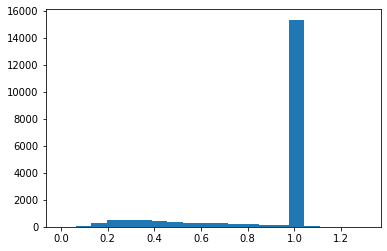

In [20]:
# Look at the distribution of the differences
# Making a histogram of the cosine variable values
plt.hist(cosine_values,bins=20)

In [21]:
print(cosine_values.describe())

count    19538.000000
mean         0.886329
std          0.241368
min          0.000000
25%          0.987674
50%          0.997423
75%          1.003376
max          1.303678
Name: cosine_dist, dtype: float64


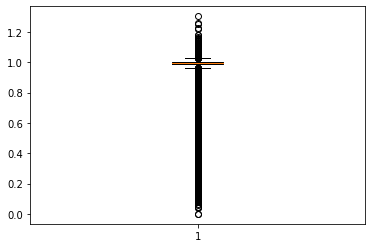

In [22]:
# As shown in the statistics for the cosine values
# The average difference between the Q and A vectors is 0.85 with std of 0.29
plt.boxplot(cosine_values)
plt.show()

In [23]:
food.head()

,asin,question,answer,cosine_dist
0,9742356831,What is the heat of this compared to the yello...,I think that the yellow is the most mild. The ...,0.992110
1,9742356831,Is there MSG in it?,No MSG in Mae Ploy curry pastes.,1.010442
2,9742356831,what are the ingredients exactly in this produ...,The ingredients are listed in the description!,0.991582
3,9742356831,How important is the expiraci&oacute;n date on...,I never pay attention to it myself. The ingred...,0.825200
4,9742356831,"The product description says 14 oz., but the p...",We bought the 14oz for just under $5.,1.003486


In [24]:
# How many questions receive answers below limit?
limit = 0.75
# Limit determined from best practice of other comparisons

wrong_answer_count = food['cosine_dist'][abs(food['cosine_dist'])<limit].count()
right_answer_count = food['cosine_dist'][abs(food['cosine_dist'])>=limit].count()
# Print percentage of potential wrong answers
print("If correctness of answer is based on cosine distance less than: ", limit)
print("Potential wrong answer count: ",wrong_answer_count)
print("Potential right answer count: ",right_answer_count)
print("Potential wrong answer percentage: ",100*wrong_answer_count/(wrong_answer_count+right_answer_count))

If correctness of answer is based on cosine distance less than:  0.75
Potential wrong answer count:  3601
Potential right answer count:  15937
Potential wrong answer percentage:  18.430750332685022


In [25]:
# Does this account for Yes answers?
yes_answers = food[(food['answer'].str.lower()=='yes') | (food['answer'].str.lower()=='yes.')]
yes_count_right = yes_answers['cosine_dist'][abs(yes_answers['cosine_dist'])>=limit].count()
yes_count_wrong = yes_answers['cosine_dist'][abs(yes_answers['cosine_dist'])<limit].count()
print("Yes answers with measure above limit: ",yes_count_right)
print("Yes answers with measure below limit: ",yes_count_wrong)
print('\nDistribution of coine_dist for YES answers',yes_answers['cosine_dist'].describe())

Yes answers with measure above limit:  403
Yes answers with measure below limit:  0

Distribution of coine_dist for YES answers count    403.000000
mean       0.999228
std        0.006757
min        0.981487
25%        0.994707
50%        0.999363
75%        1.003749
max        1.021350
Name: cosine_dist, dtype: float64


In [26]:
# Does this account for No answers?
no_answers = food[(food['answer'].str.lower()=='no') | (food['answer'].str.lower()=='no.')]
no_count_right = no_answers['cosine_dist'][abs(no_answers['cosine_dist'])>=limit].count()
no_count_wrong = no_answers['cosine_dist'][abs(no_answers['cosine_dist'])<limit].count()
print("NO answers with measure above limit: ",no_count_right)
print("NO answers with measure below limit: ",no_count_wrong)
print('\nDistribution of coine_dist for YES answers',no_answers['cosine_dist'].describe())

NO answers with measure above limit:  212
NO answers with measure below limit:  0

Distribution of coine_dist for YES answers count    212.000000
mean       0.998652
std        0.006752
min        0.973324
25%        0.994531
50%        0.998222
75%        1.002730
max        1.018318
Name: cosine_dist, dtype: float64


In [27]:
# Save cosine distance results to excel file
data_with_cosines_path = r'Capstone_Dataset/Amazon_Food_Q_A_Post_2019_Cosines_Dist.xlsx'
food.to_excel(data_with_cosines_path)

/opt/anaconda3/lib/python3.7/site-packages/xlsxwriter/worksheet.py:937: UserWarning: Ignoring URL 'http://bpafreecannedfood.wordpress.com/bpa-free-canned-food-brands/%20Native%20Forest%20(Edward%20&%20Sons)%20Updated%20on%20April%2010,%202012%20I've%20heard%20all%20of%20Native%20Forest%20Brand%60s%20canned%20foods%20are%20BPA%20free.%20I%20guess%20they%20(all%20bloggers%20out%20there)%20meant%20most%20of%20them%20are%20BPA%20Free!%20Anyway,%20thank%20you,%20Native%20Forest%20for%20listing%20all%20your%20BPA%20free%20products%20for%20me!%20%22Thank%20you%20for%20contacting%20Edward%20&%20Sons%20Trading%20Company%20with%20your%20question%20about%20BPA%20and%20metal%20cans.%20Please%20know%20that%20food%20safety%20is%20as%20important%20to%20us%20as%20it%20is%20to%20you%20and%20your%20family.%20Metal%20food%20and%20beverage%20cans%20have%20a%20thin%20coating%20on%20the%20interior%20of%20the%20can%20surface,%20which%20protects%20from%20corrosion%20of%20the%20can%20and%20contamination%20of%2

# Compare model results to new test data

In [28]:
# A sampling of Amazon Gourmet Foods product Q and A data was aquired on Sept 26-28, 2021.
# Data was manually copied from Amazon website, randomly searched for products in all
# sub categories of Gourmet Food category

# Define path for Amazon data
sample_path = r'Capstone_Dataset/Amazon_Food_Q_A_Post_2019_Sample.xlsx'
samples = pd.read_excel(sample_path)
print('Shape of the data: ',samples.shape,'\n')
samples.head()

Shape of the data:  (160, 4) 



,ASIN,question,answer,date
0,B00L26YPLQ,Is this non gmo?,"Who knows and who cares, it’s by far the best ...",2021-09-08
1,B00L26YPLQ,Salt content ?,There is 120mg of sodium in the Rao's Homemade...,2021-07-19
2,B00L26YPLQ,How many ounces is this jar?,Rao's Homemade Pizza sauce jar is 13 oz.,2021-05-12
3,B00L26YPLQ,Are the onions in this visible? Or are they bl...,All of our ingredients are blended for taste i...,2020-08-24
4,B00L26YPLQ,Gluten free correct?,Our products do not contain gluten ingredients...,2021-01-28


In [29]:
# Create samples dataframe holding the product id, question, and associated answer
samples = samples[['ASIN', 'question', 'answer']]
samples[['question', 'answer']] = samples[['question', 'answer']].astype(str)
print(samples.head(),'\n')
# Find the most common words in the samples questions keeping the stopwords
samples_question_phrases = find_phrases(samples['question'])
print("samples_Question phrases count: ",len(samples_question_phrases),'\n')
print("samples_Question phrases first 10: \n",samples_question_phrases[:10])

         ASIN                                           question  \
0  B00L26YPLQ                                   Is this non gmo?   
1  B00L26YPLQ                                     Salt content ?   
2  B00L26YPLQ                       How many ounces is this jar?   
3  B00L26YPLQ  Are the onions in this visible? Or are they bl...   
4  B00L26YPLQ                               Gluten free correct?   

                                              answer  
0  Who knows and who cares, it’s by far the best ...  
1  There is 120mg of sodium in the Rao's Homemade...  
2           Rao's Homemade Pizza sauce jar is 13 oz.  
3  All of our ingredients are blended for taste i...  
4  Our products do not contain gluten ingredients...   

samples_Question phrases count:  160 

samples_Question phrases first 10: 
 [['is', 'this', 'non', 'gmo'], ['salt', 'content'], ['how', 'many', 'ounces', 'is', 'this', 'jar'], ['are', 'the', 'onions', 'in', 'this', 'visible', 'or', 'are', 'they', 'blended', '

In [30]:
# Find the most common words in the samples answers keeping the stopwords
samples_answer_phrases = find_phrases(samples['answer'])
print("samples_Answer phrases count: ",len(samples_answer_phrases),'\n')
print("samples_Answer phrases first 10: \n",samples_answer_phrases[:10])

samples_Answer phrases count:  160 

samples_Answer phrases first 10: 
 [['who', 'knows', 'and', 'who', 'cares', 'it', 's', 'by', 'far', 'the', 'best', 'pizza', 'sauce', 'ever', 'enjoy', 'life', 'eat', 'good', 'food'], ['there', 'is', 'of', 'sodium', 'in', 'the', 'rao', 'homemade', 'pizza', 'sauce'], ['rao', 'homemade', 'pizza', 'sauce', 'jar', 'is', 'oz'], ['all', 'of', 'our', 'ingredients', 'are', 'blended', 'for', 'taste', 'in', 'the', 'pizza', 'sauce'], ['our', 'products', 'do', 'not', 'contain', 'gluten', 'ingredients', 'therefore', 'are', 'gluten', 'free', 'the', 'only', 'exception', 'is', 'the', 'vodka', 'sauce', 'which', 'contain', 'vodka'], ['hi', 'there', 'one', 'box', 'has', 'prepared', 'servings', 'and', 'one', 'serving', 'has', 'grams', 'of', 'sugar', 'the', 'full', 'nutrition', 'facts', 'are', 'shared', 'on', 'this', 'product', 'page', 'in', 'the', 'third', 'image', 'from', 'the', 'top', 'we', 'hope', 'this', 'helps'], ['hi', 'there', 'we', 'sorry', 'to', 'hear', 'that', 

In [31]:
# Infer vectors for all samples questions
samples_question_vectors = []
for q in samples_question_phrases:
    samples_question_vectors.append(model.infer_vector(q))
print("Question Vectors count: \n",len(samples_question_vectors))
print("Question Vectors example: \n",samples_question_vectors[0])

Question Vectors count: 
 160
Question Vectors example: 
 [-1.1262645e-06  8.8051212e-07 -2.6325727e-06 ... -1.2039086e-06
  1.6796552e-05  5.1654342e-06]


In [32]:
# Infer vectors for all samples answers
samples_answer_vectors = []
for a in samples_answer_phrases:
    samples_answer_vectors.append(model.infer_vector(a))
print("Question Vectors count: \n",len(samples_answer_vectors))
print("Question Vectors example: \n",samples_answer_vectors[0])

Question Vectors count: 
 160
Question Vectors example: 
 [ 0.00167758  0.00186076  0.00226724 ... -0.00241816 -0.00973021
 -0.00504975]


In [33]:
# Add feature to samples dataframe to hold the cosine distance vector between question and answer
samples['cosine_dist'] = [spatial.distance.cosine(samples_question_vectors[row], samples_answer_vectors[row]) 
                       for row,element in enumerate(samples_question_vectors)]
samples_cosine_values = samples['cosine_dist']
print("Number of values: ",len(samples_cosine_values))
print(samples_cosine_values.value_counts())

Number of values:  160
0.991063    1
1.003053    1
0.995840    1
1.009553    1
1.007647    1
           ..
0.995147    1
0.359841    1
1.000526    1
1.003472    1
1.010112    1
Name: cosine_dist, Length: 160, dtype: int64


(array([  1.,   0.,   2.,   4.,   2.,   1.,   2.,   1.,   0.,   1.,   1.,
          5.,   1.,   2.,   2.,   0.,   0.,   1.,   1., 133.]),
 array([0.1330353 , 0.17738073, 0.22172616, 0.26607159, 0.31041702,
        0.35476245, 0.39910788, 0.44345331, 0.48779875, 0.53214418,
        0.57648961, 0.62083504, 0.66518047, 0.7095259 , 0.75387133,
        0.79821676, 0.84256219, 0.88690762, 0.93125305, 0.97559848,
        1.01994391]),
 <BarContainer object of 20 artists>)

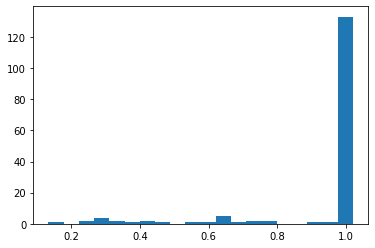

In [34]:
# Look at the distribution of the differences
# Making a histogram of the cosine variable values
plt.hist(samples_cosine_values,bins=20)

In [35]:
# Save samples results to excel file
sample_with_cosines_path = r'Capstone_Dataset/Amazon_Food_Q_A_Post_2019_Cosines_Dist_Sample.xlsx'
samples.to_excel(sample_with_cosines_path)

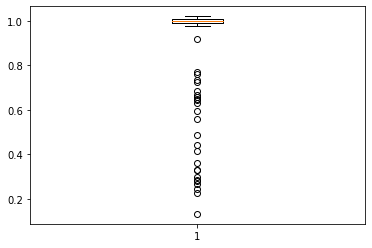

In [36]:
# As shown in the statistics for the cosine values
# The average difference between the Q and A vectors is 0.85 with std of 0.29
plt.boxplot(samples_cosine_values)
plt.show()

In [37]:
# How many questions receive answers below limit?
# From above, limit=0.75
# Limit determined from best practice of other comparisons

samples_wrong_answer_count = samples['cosine_dist'][abs(samples['cosine_dist'])<limit].count()
samples_right_answer_count = samples['cosine_dist'][abs(samples['cosine_dist'])>=limit].count()
# Print percentage of potential wrong answers
print("If correctness of answer is based on cosine distance less than: ", limit)
print("Potential wrong answer count: ",samples_wrong_answer_count)
print("Potential right answer count: ",samples_right_answer_count)
print("Potential wrong answer percentage: ",100*samples_wrong_answer_count/(samples_wrong_answer_count+samples_right_answer_count))

If correctness of answer is based on cosine distance less than:  0.75
Potential wrong answer count:  23
Potential right answer count:  137
Potential wrong answer percentage:  14.375


# Compare % wrong answers between train and sample data
When cosine distance was applied using the model to the entire test dataset,
The wrong percentage was 18.4 percent wrong

Compared to the sample dataset with 15.6 percent wrong (Newer data by 2-3 years)

# Are questions really being answered?

In [38]:
# We have seen that the alignment of vectors between questions and answers 
#.    shows 18.4% not answered
# But what of the Negative answers?
#negative_terms = ["no", "not good", "nope", "dont", 'uncertain','unclear','cant']
# Compute the number of negative responses in the list of answers

# Topic Modeling
What topics are the customers asking for in the models?  Use Topic Modeling to identify the topics

In [39]:
# Import needed libraries
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from gensim.similarities import SparseMatrixSimilarity
from gensim.models.phrases import Phrases

In [40]:
# For topic modeling we need to remove the stopwords
# Find the most common words in the cleaned questions keeping the stopwords
cleaned_question_phrases = find_phrases(samples['question'],True)
print("Cleaned_Question phrases count: ",len(cleaned_question_phrases),'\n')
print("Cleaned_Question phrases first 10: \n",cleaned_question_phrases[:10])

Cleaned_Question phrases count:  160 

Cleaned_Question phrases first 10: 
 [['non', 'gmo'], ['salt', 'content'], ['many', 'ounces', 'jar'], ['onions', 'visible', 'blended', 'taste'], ['gluten', 'free', 'correct'], ['also', 'hypoglycemic', 'ca', 'much', 'sugar', 'tell', 'total', 'sugar', 'grams', 'serving', 'size'], ['bake', 'well', 'colorado', 'need', 'differently', 'messing', 'temp', 'help', 'adding', 'cup', 'extra', 'oil', 'helped', 'eno'], ['exactly', 'product', 'people', 'ibs', 'need', 'specifics', 'gluten', 'free', 'tell', 'box'], ['anybody', 'try', 'adding', 'peanut', 'butter'], ['product', 'country']]


In [41]:
# For topic modeling we need to remove the stopwords
# Find the most common words in the cleaned answers keeping the stopwords
cleaned_answer_phrases = find_phrases(samples['answer'],True)
print("Cleaned_answer phrases count: ",len(cleaned_answer_phrases),'\n')
print("Cleaned_answer phrases first 10: \n",cleaned_answer_phrases[:10])

Cleaned_answer phrases count:  160 

Cleaned_answer phrases first 10: 
 [['knows', 'cares', 'far', 'best', 'pizza', 'sauce', 'ever', 'enjoy', 'life', 'eat', 'good', 'food'], ['sodium', 'rao', 'homemade', 'pizza', 'sauce'], ['rao', 'homemade', 'pizza', 'sauce', 'jar', 'oz'], ['ingredients', 'blended', 'taste', 'pizza', 'sauce'], ['products', 'contain', 'gluten', 'ingredients', 'therefore', 'gluten', 'free', 'exception', 'vodka', 'sauce', 'contain', 'vodka'], ['hi', 'one', 'box', 'prepared', 'servings', 'one', 'serving', 'grams', 'sugar', 'full', 'nutrition', 'facts', 'shared', 'product', 'page', 'third', 'image', 'top', 'hope', 'helps'], ['hi', 'sorry', 'hear', 'bit', 'trouble', 'mix', 'suggest', 'checking', 'high', 'altitude', 'baking', 'chart', 'suggestions', 'adjustments', 'make', 'https', 'wo', 'able', 'adjust', 'ingredients', 'like', 'sugar', 'leavener', 'chart', 'elements', 'try', 'altering', 'hope', 'helps', 'morgan', 'kaf'], ['hi', 'glad', 'know', 'include', 'ingredients', 'king

In [42]:
print(cleaned_question_phrases[:5])

[['non', 'gmo'], ['salt', 'content'], ['many', 'ounces', 'jar'], ['onions', 'visible', 'blended', 'taste'], ['gluten', 'free', 'correct']]


# Build A Bigram

In [43]:
#Build a Bigram so that two word phrases are linked together
bigram = Phrases(cleaned_question_phrases, min_count=1, threshold=1) #train model
cleaned_question_phrases_bigram= [bigram[line] for line in cleaned_question_phrases]

In [44]:
# Look at found two word phrases
for phrase, score in bigram.find_phrases(cleaned_question_phrases).items():
    print(phrase, score)

non_gmo 249.0
gluten_free 53.357142857142854
taste_like 62.25
expiration_date 166.0
many_boxes 23.71428571428571
anyone_know 166.0
longer_available 132.8
made_usa 66.4
dairy_free 31.125
country_origin 166.0
oz_bag 62.25
cows_grass 166.0
many_bunches 35.57142857142857
ebt_card 124.5
iced_tea 166.0


In [45]:
# create a dictionary from the questions 
dictionary = Dictionary(cleaned_question_phrases_bigram)

In [46]:
# Create a gensim corpus
# This ia bag of words for the text in the format (token_id, token_count) 2 tuples
bow_corpus = [dictionary.doc2bow(token) for token in cleaned_question_phrases]
print(bow_corpus)

[[], [(1, 1), (2, 1)], [(3, 1), (4, 1), (5, 1)], [(6, 1), (7, 1), (8, 1), (9, 1)], [(10, 1), (201, 1)], [(12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1)], [(22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1)], [(20, 1), (32, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (201, 1)], [(22, 1), (42, 1), (43, 1), (44, 1), (45, 1)], [(40, 1), (46, 1)], [(20, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1)], [(59, 1), (60, 1), (61, 1)], [(62, 1), (63, 1), (64, 2)], [(8, 1), (65, 1), (160, 1)], [(67, 1), (68, 1), (69, 1), (70, 1)], [(71, 1)], [(72, 1), (73, 1), (74, 1), (75, 1)], [(74, 1), (76, 1), (77, 1), (78, 1)], [(74, 1), (79, 1)], [(12, 1), (80, 1), (81, 1)], [(82, 1), (201, 1)], [(83, 1)], [(4, 1), (84, 1), (85, 1), (86, 1)], [(87, 1), (88, 1)], [(40, 1), (89, 1)], [(201, 1)], [(90, 1), (91, 1), (92, 

In [47]:
# To understand tuples better, print out in better format
[[(dictionary[i], freq) for i, freq in doc] for doc in bow_corpus[:3]]

[[], [('content', 1), ('salt', 1)], [('jar', 1), ('many', 1), ('ounces', 1)]]

# TF-IDF with Gensim

Building a TF-IDF model using gensim model. 
The tf-idf model transforms vectors from the bag-of-words 
to a vectors where the frequency counts 
are weighted according to the rarity of each word in the corpus.

tfidf is a read-only object that can be used to convert a vector from a previous 
form (bag-of-words integer counts) to new form 

In [48]:
# Initialize model
tfidf = TfidfModel(bow_corpus) 
# Apply transformation to the entire corpus
corpus_tfidf = tfidf[bow_corpus] 

In [49]:
for doc, as_text in zip(corpus_tfidf, question_phrases):
    print(doc, as_text, end='\n\n')

[] ['what', 'is', 'the', 'heat', 'of', 'this', 'compared', 'to', 'the', 'yellow', 'and', 'red', 'curry']

[(1, 0.6535277768598731), (2, 0.7569025332713532)] ['is', 'there', 'msg', 'in', 'it']

[(3, 0.5926367485999575), (4, 0.3913741750594899), (5, 0.7039942750515621)] ['what', 'are', 'the', 'ingredients', 'exactly', 'in', 'this', 'product', 'thanks']

[(6, 0.5323739087647885), (7, 0.5323739087647885), (8, 0.3869548601574891), (9, 0.5323739087647885)] ['how', 'important', 'is', 'the', 'expiraci', 'oacute', 'n', 'date', 'on', 'this', 'curry', 'paste']

[(10, 0.9015207668634451), (201, 0.432735839645789)] ['the', 'product', 'description', 'says', 'but', 'the', 'picture', 'shows', 'the', 'lb', 'oz', 'version', 'which', 'is', 'it', 'thanks']

[(12, 0.20471012502921582), (13, 0.31642045650600703), (14, 0.31642045650600703), (15, 0.31642045650600703), (16, 0.24792558035811368), (17, 0.31642045650600703), (18, 0.24792558035811368), (19, 0.5464100023542183), (20, 0.24792558035811368), (21, 0.27

In [50]:
# Apply the model to the document:
corpus_tfidf[1]

[(1, 0.6535277768598731), (2, 0.7569025332713532)]

In [51]:
# The most relevant term is 1 followed by 2
# Find these terms
print("Top term: : ",dictionary[1])
print("2nd highest term: : ",dictionary[2])

Top term: :  content
2nd highest term: :  salt


# The most relative terms in the questions are "content" and "salt"

# Apply Gensim Topic Modeling using Hdp

In [52]:
def visualize_top_words(model):
    n_words = 10
    topic_words = pd.DataFrame({})
    
    for i, topic in enumerate(model.get_topics()[:5]):
        top_feature_ids = topic.argsort()[-n_words:][::-1]
        feature_values = topic[top_feature_ids]
        words = [dictionary[id] for id in top_feature_ids]
        topic_df = pd.DataFrame({'value': feature_values, 'word': words, 'topic': i})
        topic_words = pd.concat([topic_words, topic_df], ignore_index=True)

    return topic_words

In [53]:
# Apply models from gensim for topic modeling
# Use Hdp Model for unsupervised model - since we have no absolute confirmation on questions being answered
from gensim.models import HdpModel

hdpmodel = HdpModel(corpus=bow_corpus,id2word=dictionary)
hdpmodel.show_topics(num_topics=5)  #shows the top 5 topics

[(0,
  '0.017*recieved + 0.011*dry + 0.010*contact + 0.010*crushed + 0.009*correct + 0.009*arrived + 0.009*price + 0.009*intentionally + 0.008*life + 0.008*jar + 0.008*boxes + 0.008*total + 0.008*questionable + 0.008*cheese + 0.008*responsibly + 0.008*ounces + 0.008*color + 0.007*basil + 0.007*kosher + 0.007*per'),
 (1,
  '0.014*creamy + 0.012*unlike + 0.012*regular + 0.011*lasagna + 0.010*add + 0.010*last + 0.010*blended + 0.009*bending + 0.008*salads + 0.008*sprout + 0.008*changes + 0.007*love + 0.007*shelf + 0.007*appreciate + 0.007*subways + 0.007*front + 0.007*supposed + 0.007*say + 0.007*boxes + 0.007*w'),
 (2,
  '0.014*eligible + 0.012*completely + 0.012*refrigerate + 0.011*go + 0.010*pesticide + 0.010*msg + 0.009*pasta + 0.009*cancel + 0.008*help + 0.008*refrigerated + 0.008*bake + 0.008*olives + 0.008*sprouts + 0.008*noticed + 0.007*possible + 0.007*packs + 0.007*ordered + 0.007*bread + 0.007*basil + 0.007*brand'),
 (3,
  '0.012*tea + 0.011*gluten_free + 0.010*intentionally + 

In [54]:
# How many topics does Hdp Start With?
topics_num = hdpmodel.get_topics()
topics_num.shape[0]

150

In [55]:
# Visualize top Hdp Predictions
df_hdp = visualize_top_words(model=hdpmodel)      
print("shape of topic model: ",df_hdp.shape,'\n')
df_hdp.head()

shape of topic model:  (50, 3) 



,value,word,topic
0,0.017193,recieved,0
1,0.011470,dry,0
2,0.010470,contact,0
3,0.009632,crushed,0
4,0.009031,correct,0


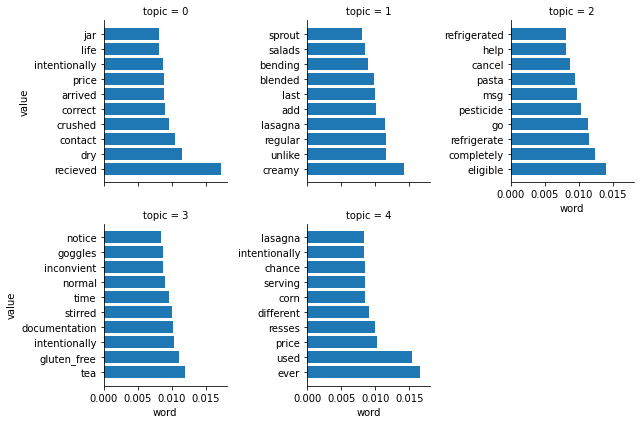

In [56]:
g = sns.FacetGrid(df_hdp, col="topic", col_wrap=3, sharey=False)
g.map(plt.barh, "word", "value");

In [57]:
# Topic Modeling Evaluation
# Use Topic Coherence to evaluate
from gensim.models.coherencemodel import CoherenceModel
hdp_coherence = CoherenceModel(model=hdpmodel, corpus=bow_corpus, 
                               texts = cleaned_question_phrases_bigram, coherence='c_v')
# higher coherence score is better
print('HDP Model coherence :', hdp_coherence.get_coherence())

HDP Model coherence : 0.8131967820098313


# Conclusions from Topic Modeling

The topic modeling identified 5 top topics with a model coherence of 80.9%, which is a strong score
The topics were:
## 1) Supposed (A mixture between application and intended purpose for product, and complaints on ingredients)

## 2) W (Customer concerns over contradictions noticed, eligibility, details, additions)

## 3) Sources (location of manufacture or sourcing)

## 4) Line (Customer complaints on product claims or features)

## 5) Pack (understanding of quantities included in packaging, options for sizing)


These five topics were frequent on the customer's minds and were ongoing questions to be answered.
This is an opportunity for Amazon to lead their customers with clarity to pre clarify these features of understanding

### Topics asking for clarity: (opportunites to increase sales on clearer feature information)

1) How is food supposed to be combined or used.  Questions of preparation or ingredients listings

3) Sourcing information on where it is manufactured or sourced from (state and/or country)

5) Quantities in packaging, how much there and options for other sized

### Topics identify potential customer complaints and issues: (opportunity to address customer concerns)

1) While topic 1 is about how food is to be combined or prepared, it has inherent questions on ingredients that link to concerns over allergies

2) There were multiple customer callouts where they "noticed" errors or contradictions.  This is the customer shouting at Amazon that there is an error in the product packaging or presentation that needs correction

4) Similar to 1 and 2, the topic is customer complaints on product claims or features

## Apply BERT to questions and answers
Bidirectional Encoder Representations from Transformers
Found at: https://www.blog.google/products/search/search-language-understanding-bert/
According to the site "BERT models can therefore consider the full context of a word by looking at the words that come before and after it"
Must include all stopwords when applying BERT models

In [58]:
# For DistilBERT:  lighter version better for running on local computer
import transformers as ppb
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [59]:
# BERT wants to process all lines at once, and they must be same length
# Padding question embeddings so that each line is same length
max_q_len = 0
for q in question_embeddings:
    if len(q) > max_q_len:
        max_q_len = len(q)

q_padded = np.array([q + [0]*(max_q_len-len(q)) for q in question_embeddings])
# Masking to point to areas with non zero values
attention_q_mask = np.where(q_padded != 0, 1, 0)


# Padding answer embeddings so that each line is same length
max_a_len = 0
for a in answer_embeddings:
    if len(a) > max_a_len:
        max_a_len = len(a)

a_padded = np.array([a + [0]*(max_a_len-len(a)) for a in question_embeddings])
# Masking to point to areas with non zero values
attention_a_mask = np.where(a_padded != 0, 1, 0)

NameError: name 'question_embeddings' is not defined

In [ ]:
# Run the BERT Model
input_q_ids = torch.tensor(q_padded)  
attention_q_mask = torch.tensor(attention_q_mask)

with torch.no_grad():
    last_hidden_states = model(input_q_ids, attention_mask=attention_q_mask)

In [ ]:
# clean the phrase by removing non letters and lower case, remove stop words on request
def clean_phrase(phrase, stopwords=False):
    phrase = phrase.lower().strip()
    phrase = re.sub(r'[^a-z0-9\s]','',phrase)
    
    if stopwords:
        phrase = remove_stopwords(phrase)
    return phrase

# call cleaned for entire dataframe for one feature column and return list of words
def clean_all(df,feature,stopwords=False):
    column = df[[feature]]
    cleaned = []
    for index,row in df.iterrows():
        cleaned_val = clean_phrase(row[feature],stopwords)
        cleaned.append(cleaned_val)
    return cleaned


questions_cleaned = clean_all(food,'question',stopwords=False)
print("Count of questions: ",len(questions_cleaned))

answers_cleaned = clean_all(food,'answer',stopwords=False)
print("\nTop 20 Answer words: \n",answer_words[:20])
print("Count of answers: ",len(answers_cleaned))